# **SV With CLR**

We would like to use CLR for SV models. First we load the necessary components:

In [65]:
import numpy as np
import genDat as gd
import utils as ut
from clr import *
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, TimeDistributed, SimpleRNN, Input, Activation
from keras.utils import to_categorical
from keras import optimizers
from keras import initializers
from keras import backend as K
from keras import callbacks
import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras.constraints import MaxNorm

We define a few parameters which will help define our neural network and training regime:

In [66]:

# Number of hidden layers
num_hidden = 8
# Number of nodes per hidden layer
nodes = 32
# Size of batches in each step
batch_size = 64
# Training Sample Size
train_n = 75
# Testing Sample Size
test_n = 75
# Testing Batch Size
t_batch_size=500
# Learning rate
step_size = 0.001
# Learning rate decay
decay_size = .0001
# Number of steps per epoch
steps_per_epoch = 200
# Number of epochs
num_epochs = 100
# Number of epochs to run before starting model averaging
burn_in = 100.0

Next we specify prior parameters and pinball parameter (we are interested in the posterior median of mu):

In [67]:
# PRIOR PARAMETERS

# Specify mean and SD for level of log variance
b_k = 0
B_mu = 10
# Specify beta prior parameters for the persistance of the log variance
a_0 = 7
b_0 = 1.5
# Specify scalar on chi squared (1) prior for volatility of log variance
B_sigma = 1.5


# LOSS STUFF


# Pinball parameter
tao = 0.5
quant = np.array([0.5])

Functions to generate data from prior as well as save interations:

In [68]:
def gen_batch(m, n, b_k,B_mu,a_0,b_0,B_sigma):
  # Sample from the prior
  mu = B_mu*np.random.randn(m)
  phi = 2.0*np.random.beta(a_0,b_0,m)-1.0
  sigma = B_sigma*np.random.chisquare(1,m)
  # Create hidden volatility rv's and observed path rv's
  y = np.zeros([m,n])
  h = np.zeros([m,n])
  # Generate Initial Volatility
  h[:,0]= np.random.normal(mu, np.sqrt(sigma/(1.0-np.power(phi,2))))
  y[:,0]= np.random.normal(0,np.sqrt(np.exp(h[:,0])))
  # Sequentially generate values
  for i in range(n-1):
        h[:,i+1]= np.random.normal(mu+phi*(h[:,i]-mu),np.sqrt(sigma))
        y[:,i+1]= np.random.normal(0,np.sqrt(np.exp(h[:,i+1])))
  X = y
  labels = mu
  return({"X":X, "theta":labels})



In [69]:
# Build Model
model = Sequential()
# Add input layer
model.add(SimpleRNN(nodes, return_sequences=True, input_shape=(None, 1)))
# Add additional hidden layers
for i in range(num_hidden-1):
      model.add(SimpleRNN(nodes, return_sequences=True))
# Add output layer
model.add(SimpleRNN(1, activation = None))
# Define data iterator
def genTraining(batch_size,train_n,b_k,B_mu,a_0,b_0,B_sigma):
    while True:
        # Get training data for step
        dat = gd.gen_batch(batch_size, train_n, b_k,B_mu,a_0,b_0,B_sigma)
        junk = ut.setup_nn_mat(dat)
        # We repeat the labels for each x in the sequence
        if(np.linalg.norm(junk['outcome'])<1e10 and np.linalg.norm(junk['W']<1e10)):
              batch_labels = junk['outcome']
              batch_data = junk['W'].reshape((batch_size,train_n,1))
        else:
              batch_labels = np.ones([1,])
              batch_data = np.ones([batch_size,train_n,1])
        yield batch_data,batch_labels
        
        
        
        
        
        
        
# Define callback for model averaging
class average(callbacks.Callback):
  def __init__(self,test,exact,num_hidden):
    self.test = test   # get test data
    self.exact = exact # get exact labels
    self.avg_loss = []
    self.n = 0
    # Build Model
    self.avg_model = Sequential()
    # Add input layer
    self.avg_model.add(SimpleRNN(nodes, return_sequences=True, input_shape=(None, 1)))
    # Add additional hidden layers
    for i in range(num_hidden-1):
          self.avg_model.add(SimpleRNN(nodes, return_sequences=True))
    # Add output layer
    self.avg_model.add(SimpleRNN(1))

  def on_epoch_end(self, epoch, logs={}):
    new_weights = model.get_weights()
    curr_weights = self.avg_model.get_weights()
    if(self.n >burn_in):
          for i in range(np.size(curr_weights)):
                curr_weights[i] = (1.0)/(self.n-burn_in)*new_weights[i] + ((self.n-1.0-burn_in)/(self.n - burn_in))*curr_weights[i]
          self.avg_model.set_weights(curr_weights)
          self.avg_loss.append(K.eval(pinball(self.avg_model.predict(self.test)[:,0],self.exact)))
          print("Averaged model loss: {:01.6f}".format(self.avg_loss[-1]))
    
    self.n = self.n+1



In [70]:
### setting stuff up for the NN (not really used here)
import numpy as np
import scipy.stats as sps

def setup_nn_mat(dat):
    return({"outcome":dat['theta'], "W":dat['X']})

## Calculating exact conditional quantiles in the gaussian-gaussian scenario
def calc_quants(dat, quants, sigma_theta_squared):
    m,n = dat['X'].shape    
    n_quant = quants.size
    cond_quants = np.zeros((m,n_quant))
    for i in range(m):
        for j in range(n_quant):
            x_bar = np.mean(dat['X'][i,:])
            mean_ppf = x_bar*sigma_theta_squared/(pow(n,-1) + sigma_theta_squared)
            sd_ppf = pow(n + 1/sigma_theta_squared, -0.5)
            cond_quants[i,j] = sps.norm.ppf(quants[j], mean_ppf, sd_ppf)
    return(cond_quants)

## evaluating the difference between predicted and true quantiles
def eval_diff(pred_quants, exact_quants):
   diff_abs = np.mean(np.abs(pred_quants - exact_quants))
   return(diff_abs)


In [71]:
def pinball(y_true, y_pred):
    pin = K.mean(K.maximum(y_true - y_pred, 0) * tao +
                 K.maximum(y_pred - y_true, 0) * (1 - tao))
    return pin

In order to use CLR, we must first do a LR-Range Test. We can do this with the CLR callback functions.

In [72]:
lr_callback = LRFinder(300, 1,
                       1e-5, 10.,
                       lr_scale='exp', save_dir='weights/',verbose = True)

In [73]:
## Calulations, no need to edit
np.random.seed(12345)

# Create Testing Data
t_dat = gd.gen_batch(t_batch_size, test_n, b_k,B_mu,a_0,b_0,B_sigma)
junk = ut.setup_nn_mat(t_dat)
t_batch_labels = junk['outcome']


t_batch_data = junk['W'].reshape((t_batch_size,test_n,1))

In [74]:
model.compile(loss= pinball,
              optimizer=optimizers.SGD(lr=0.001,
                                       momentum=0.9,
                                       nesterov=True,
                                       clipnorm = 0.5,
                                       clipvalue = 0.5),
              metrics = ["mean_squared_error"])           
# Train the model
history = model.fit_generator(genTraining(batch_size,train_n,b_k,B_mu,a_0,b_0,B_sigma),
                              epochs=1,
                              steps_per_epoch=300,
                              validation_data = (t_batch_data,t_batch_labels),
                              callbacks= [lr_callback])

Epoch 1/1
 64/300 [=====>........................] - ETA: 42s - loss: 4.6232 - mean_squared_error: 132.9204 - LRFinder: lr = 0.00019055 


128/300 [===========>..................] - ETA: 28s - loss: 4.2602 - mean_squared_error: 116.9386 - LRFinder: lr = 0.00363078 


192/300 [==================>...........] - ETA: 17s - loss: 3.9782 - mean_squared_error: 104.9431 - LRFinder: lr = 0.06918309 


256/300 [========================>.....] - ETA: 6s - loss: 16.2903 - mean_squared_error: 231558.3579 - LRFinder: lr = 1.25892553 


299/300 [============================>.] - ETA: 0s - loss: nan - mean_squared_error: nan - LRFinder: lr = 3.80189387 
 - LRFinder: lr = 3.98107169 
300/300 [==============================] - 46s 154ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
	LR Finder : Saved the losses and learning rate values in path : {weights/}


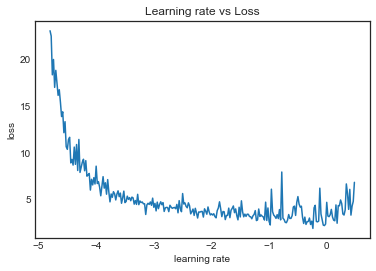

In [75]:
LRFinder.plot_schedule_from_file('weights/', clip_beginning=10, clip_endding=5)

In [92]:
best_max = -2.0
lr_manager = OneCycleLR(max_lr=10**best_max, 
                        maximum_momentum=0.95, 
                        verbose=True)


In [93]:
# Build Model
model = Sequential()
# Add input layer
model.add(SimpleRNN(nodes, return_sequences=True, input_shape=(None, 1)))
# Add additional hidden layers
for i in range(num_hidden-1):
      model.add(SimpleRNN(nodes, return_sequences=True))
# Add output layer
model.add(SimpleRNN(1, activation = None))

In [94]:
model.compile(loss= pinball,
              optimizer=optimizers.SGD(lr=0.00001,
                                       momentum=0.9,
                                       nesterov=True,
                                       clipnorm = 0.5,
                                       clipvalue = 0.5),
              metrics = ["mean_squared_error"])           
# Train the model
history = model.fit_generator(genTraining(batch_size,train_n,b_k,B_mu,a_0,b_0,B_sigma),
                              epochs=num_epochs,
                              steps_per_epoch=steps_per_epoch,
                              validation_data = (t_batch_data,t_batch_labels),
                              callbacks= [lr_manager])

Epoch 1/100
  2/200 [..............................] - ETA: 39:30 - loss: 5.5170 - mean_squared_error: 221.1912

C:\Users\thaye_000\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.680326). Check your callbacks.
  % delta_t_median)


200/200 [==============================] - 89s 447ms/step - loss: 2.1459 - mean_squared_error: 39.2858 - val_loss: 1.3586 - val_mean_squared_error: 16.9142
 - lr: 0.00120 - momentum: 0.95 
Epoch 2/100
200/200 [==============================] - 59s 295ms/step - loss: 1.1599 - mean_squared_error: 12.2997 - val_loss: 0.9533 - val_mean_squared_error: 9.3694
 - lr: 0.00140 - momentum: 0.95 
Epoch 3/100
200/200 [==============================] - 58s 290ms/step - loss: 0.9449 - mean_squared_error: 8.0177 - val_loss: 0.9357 - val_mean_squared_error: 9.4383
 - lr: 0.00160 - momentum: 0.94 
Epoch 4/100
200/200 [==============================] - 56s 279ms/step - loss: 0.9184 - mean_squared_error: 7.7375 - val_loss: 0.8906 - val_mean_squared_error: 8.3113
 - lr: 0.00180 - momentum: 0.94 
Epoch 5/100
200/200 [==============================] - 59s 293ms/step - loss: 0.8870 - mean_squared_error: 7.3039 - val_loss: 0.9233 - val_mean_squared_error: 7.9764
 - lr: 0.00200 - momentum: 0.94 
Epoch 6/100
20

200/200 [==============================] - 58s 288ms/step - loss: 0.6601 - mean_squared_error: 4.5798 - val_loss: 0.6499 - val_mean_squared_error: 5.4470
 - lr: 0.00940 - momentum: 0.86 
Epoch 43/100
200/200 [==============================] - 54s 270ms/step - loss: 0.6863 - mean_squared_error: 4.8560 - val_loss: 0.6402 - val_mean_squared_error: 5.2215
 - lr: 0.00960 - momentum: 0.85 
Epoch 44/100
200/200 [==============================] - 56s 281ms/step - loss: 0.6637 - mean_squared_error: 4.6669 - val_loss: 0.5538 - val_mean_squared_error: 3.9863
 - lr: 0.00980 - momentum: 0.85 
Epoch 45/100
200/200 [==============================] - 56s 279ms/step - loss: 0.6760 - mean_squared_error: 4.7250 - val_loss: 0.7391 - val_mean_squared_error: 4.8964
 - lr: 0.01000 - momentum: 0.85 
Epoch 46/100
200/200 [==============================] - 57s 283ms/step - loss: 0.6627 - mean_squared_error: 4.5497 - val_loss: 0.7264 - val_mean_squared_error: 4.8677
 - lr: 0.00980 - momentum: 0.85 
Epoch 47/100


200/200 [==============================] - 55s 275ms/step - loss: 0.4940 - mean_squared_error: 3.0677 - val_loss: 0.4711 - val_mean_squared_error: 3.1526
 - lr: 0.00240 - momentum: 0.93 
Epoch 84/100
200/200 [==============================] - 55s 274ms/step - loss: 0.4990 - mean_squared_error: 2.9697 - val_loss: 0.5265 - val_mean_squared_error: 3.5008
 - lr: 0.00220 - momentum: 0.94 
Epoch 85/100
200/200 [==============================] - 56s 279ms/step - loss: 0.4874 - mean_squared_error: 2.9769 - val_loss: 0.4673 - val_mean_squared_error: 3.1439
 - lr: 0.00200 - momentum: 0.94 
Epoch 86/100
200/200 [==============================] - 55s 275ms/step - loss: 0.4779 - mean_squared_error: 2.8790 - val_loss: 0.4702 - val_mean_squared_error: 2.9819
 - lr: 0.00180 - momentum: 0.94 
Epoch 87/100
200/200 [==============================] - 54s 272ms/step - loss: 0.4735 - mean_squared_error: 2.8726 - val_loss: 0.4518 - val_mean_squared_error: 2.8448
 - lr: 0.00160 - momentum: 0.94 
Epoch 88/100


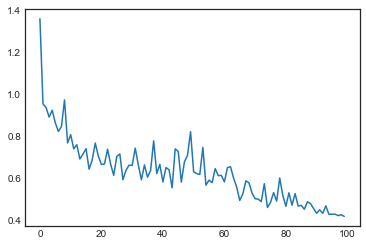

In [97]:
0.5*np.mean(np.abs(model.predict(t_batch_data)[:,0]-t_batch_labels))
plt.plot(history.history['val_loss'])

In [85]:
model.compile(loss= pinball,
              optimizer=optimizers.SGD(lr=0.00003,
                                       momentum=0.9,
                                       nesterov=True,
                                       clipnorm = 0.5,
                                       clipvalue = 0.5),
              metrics = ["mean_squared_error"])       
history = model.fit_generator(genTraining(batch_size,train_n,b_k,B_mu,a_0,b_0,B_sigma),
                              epochs=50,
                              steps_per_epoch=steps_per_epoch,
                              validation_data = (t_batch_data,t_batch_labels))

Epoch 1/50
200/200 [==============================] - 36s 180ms/step - loss: 0.5757 - mean_squared_error: 4.0593 - val_loss: 0.5615 - val_mean_squared_error: 4.0948
Epoch 2/50
200/200 [==============================] - 33s 164ms/step - loss: 0.5706 - mean_squared_error: 3.8479 - val_loss: 0.5636 - val_mean_squared_error: 4.1655
Epoch 3/50
200/200 [==============================] - 35s 177ms/step - loss: 0.5738 - mean_squared_error: 3.8695 - val_loss: 0.5410 - val_mean_squared_error: 3.5049
Epoch 4/50
200/200 [==============================] - 29s 143ms/step - loss: 0.5791 - mean_squared_error: 4.0688 - val_loss: 0.5678 - val_mean_squared_error: 4.0275
Epoch 5/50
200/200 [==============================] - 30s 152ms/step - loss: 0.5929 - mean_squared_error: 4.2900 - val_loss: 0.5703 - val_mean_squared_error: 4.1659
Epoch 6/50
200/200 [==============================] - 30s 148ms/step - loss: 0.5802 - mean_squared_error: 4.1359 - val_loss: 0.5599 - val_mean_squared_error: 4.0700
Epoch 7/50

200/200 [==============================] - 27s 137ms/step - loss: 0.5793 - mean_squared_error: 4.1356 - val_loss: 0.5529 - val_mean_squared_error: 4.1259


In [87]:
# Save test data
np.savetxt("labels.csv", t_batch_labels, delimiter=",")
np.savetxt("data.csv", t_batch_data[:,:,0], delimiter=",")
np.savetxt("rnn_preds.csv", model.predict(t_batch_data), delimiter=",")

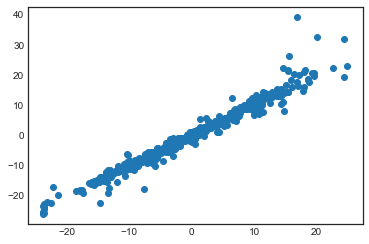

In [89]:
plt.scatter(model.predict(t_batch_data),t_batch_labels)

In [ ]:
np.savetxt("loss",)

In [96]:
np.savetxt("loss",history.history['val_loss'])

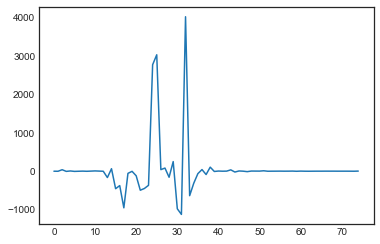

In [103]:
plt.plot(list(range(75)),t_batch_data[1,:,0])

In [99]:
np.shape(t_batch_data)

(500, 75, 1)